In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from transformers import DistilBertModel, RobertaModel
from flair.embeddings import TransformerDocumentEmbeddings
from datetime import datetime
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, f1_score, precision_score, recall_score
from sklearn.utils import shuffle
from transformers import pipeline
from gensim.models.keyedvectors import KeyedVectors
import os
import re
import json
from utils.helpers import *
pd.set_option("display.max_columns", None)
#pd.set_option('display.max_rows', 500)
pd.options.plotting.backend='matplotlib'
pd.options.mode.chained_assignment = None  # default='warn'

# Import handlabelled data

In [2]:
handlabel_df = pd.read_csv('../data/handlabel.csv')
handlabel_df.head(2)

,sequence,communication,waiting time,information,user interface,facilities,location,price,sentiment
0,satisfied with the answer,0,0,1,0,0,0,0,1
1,Friendly employee,1,0,0,0,0,0,0,1


In [3]:
handlabel_df.sentiment.value_counts()

 1    127
-1     83
 0     17
Name: sentiment, dtype: int64

In [4]:
handlabel_df['sentiment'] = handlabel_df['sentiment'].apply(lambda x: 1 if x in [0,1] else 0)

In [5]:
handlabel_df['sentiment'].value_counts()

1    144
0     83
Name: sentiment, dtype: int64

# Load transformers

In [3]:
facebook = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli", device=0, framework='pt'
                     )

In [8]:
sst = pipeline(
    model="distilbert-base-uncased-finetuned-sst-2-english",
    task="sentiment-analysis",
    return_all_scores=True
)

In [9]:
twitter = pipeline(
    model="cardiffnlp/twitter-roberta-base-sentiment",
    task="sentiment-analysis",
    return_all_scores=True,
)

In [10]:
text='The price is $50'

In [11]:
labels = ['positive', 'negative']
facebook(text, labels, multi_label=False) #, hypothesis_template = 'The sentiment of this text is {}')

{'sequence': 'The price is $50',
 'labels': ['positive', 'negative'],
 'scores': [0.5607846975326538, 0.4392153024673462]}

In [12]:
sst(text)

[[{'label': 'NEGATIVE', 'score': 0.1237640306353569},
  {'label': 'POSITIVE', 'score': 0.8762359619140625}]]

In [13]:
twitter(text)

[[{'label': 'LABEL_0', 'score': 0.09768445789813995},
  {'label': 'LABEL_1', 'score': 0.8349465131759644},
  {'label': 'LABEL_2', 'score': 0.06736910343170166}]]

# Get labels with highest probability from transformers

In [16]:
def get_sentiment_label_twitter(list_of_sent_dicts):
    if list_of_sent_dicts[0]['score'] >= 0.5:
        return 0
    else:
        return 1

In [17]:
get_sentiment_label_twitter(twitter(text)[0])

1

In [18]:
def get_sentiment_label_facebook(list_of_sent_dicts):
    if list_of_sent_dicts['labels'][0] == 'negative':
        return 0
    else:
        return 1

In [19]:
labels = ['positive', 'negative']
get_sentiment_label_facebook(facebook(text, labels, multi_label=False))

1

In [20]:
def get_sentiment_label_sst(list_of_sent_dicts):
    arg_max = np.array([i['score'] for i in list_of_sent_dicts]).argmax()
    return arg_max

In [21]:
get_sentiment_label_sst(sst(text)[0])

1

In [25]:
sentiment_handlabel_df = handlabel_df[['sequence', 'sentiment']]

# Make predictions with each of the transformers
sentiment_handlabel_df['predicted_sentiment_twitter'] = sentiment_handlabel_df['sequence'].apply(lambda x: get_sentiment_label_twitter(twitter(x)[0]))
sentiment_handlabel_df['predicted_sentiment_facebook'] = sentiment_handlabel_df['sequence'].apply(lambda x: get_sentiment_label_facebook(facebook(x, candidate_labels=['positive', 'negative'], hypothesis_template='The sentiment of this is {}')))
sentiment_handlabel_df['predicted_sentiment_sst'] = sentiment_handlabel_df['sequence'].apply(lambda x: get_sentiment_label_sst(sst(x)[0]))

sentiment_handlabel_df.head()

C:\Users\USER\AppData\Roaming\Python\Python38\site-packages\transformers\pipelines\base.py:976: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


,sequence,sentiment,predicted_sentiment_twitter,predicted_sentiment_facebook,predicted_sentiment_sst
0,satisfied with the answer,1,1,1,1
1,Friendly employee,1,1,1,1
2,It took only a little time to fixed the proble...,1,1,1,0
3,I am satisfied with the carry-in service becau...,1,1,1,1
4,Easy and beautiful,1,1,1,1


In [26]:
# Combine results from transformers using majority vote
sentiment_handlabel_df['predicted_sentiment_combined'] = sentiment_handlabel_df[['predicted_sentiment_twitter', 'predicted_sentiment_facebook', 'predicted_sentiment_sst']].sum(axis=1)
sentiment_handlabel_df['predicted_sentiment_combined'] = sentiment_handlabel_df['predicted_sentiment_combined'].apply(lambda x: 1 if x >= 2 else 0)
sentiment_handlabel_df.head()

,sequence,sentiment,predicted_sentiment_twitter,predicted_sentiment_facebook,predicted_sentiment_sst,predicted_sentiment_combined
0,satisfied with the answer,1,1,1,1,1
1,Friendly employee,1,1,1,1,1
2,It took only a little time to fixed the proble...,1,1,1,0,1
3,I am satisfied with the carry-in service becau...,1,1,1,1,1
4,Easy and beautiful,1,1,1,1,1


In [27]:
# Score each transformer

print('--------------TWITTER--------------')
print(classification_report(y_true = sentiment_handlabel_df['sentiment'],
                           y_pred = sentiment_handlabel_df['predicted_sentiment_twitter'],
                           target_names=['negative', 'positive']))
print('\n')

print('--------------FACEBOOK--------------')
print(classification_report(y_true = sentiment_handlabel_df['sentiment'],
                           y_pred = sentiment_handlabel_df['predicted_sentiment_facebook'],
                           target_names=['negative', 'positive']))
print('\n')

print('--------------SST--------------')
print(classification_report(y_true = sentiment_handlabel_df['sentiment'],
                           y_pred = sentiment_handlabel_df['predicted_sentiment_sst'],
                           target_names=['negative', 'positive']))
print('\n')

print('--------------COMBINED--------------')
print(classification_report(y_true = sentiment_handlabel_df['sentiment'],
                           y_pred = sentiment_handlabel_df['predicted_sentiment_combined'],
                           target_names=['negative', 'positive']))
print('\n')

--------------TWITTER--------------
              precision    recall  f1-score   support

    negative       0.92      0.41      0.57        83
    positive       0.74      0.98      0.84       144

    accuracy                           0.77       227
   macro avg       0.83      0.69      0.71       227
weighted avg       0.81      0.77      0.74       227



--------------FACEBOOK--------------
              precision    recall  f1-score   support

    negative       0.92      0.65      0.76        83
    positive       0.83      0.97      0.89       144

    accuracy                           0.85       227
   macro avg       0.87      0.81      0.83       227
weighted avg       0.86      0.85      0.84       227



--------------SST--------------
              precision    recall  f1-score   support

    negative       0.79      0.76      0.77        83
    positive       0.86      0.88      0.87       144

    accuracy                           0.84       227
   macro avg       

--------------TWITTER--------------


--------------FACEBOOK--------------


--------------SST--------------


--------------COMBINED--------------




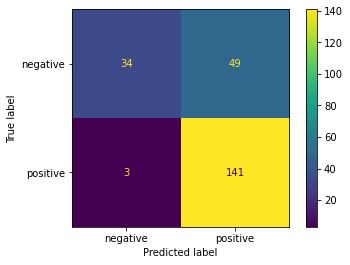

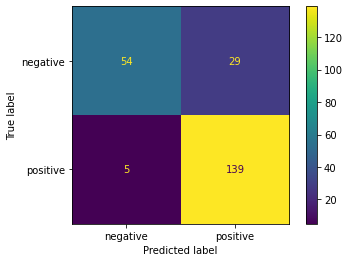

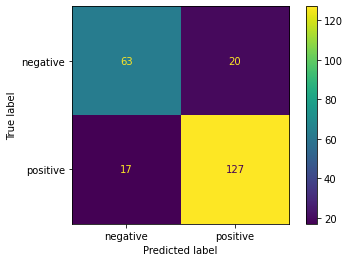

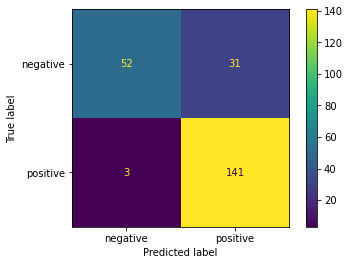

In [33]:
print('--------------TWITTER--------------')
cm = confusion_matrix(y_true = sentiment_handlabel_df['sentiment'],
                           y_pred = sentiment_handlabel_df['predicted_sentiment_twitter']
                           )

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive']).plot()
print('\n')

print('--------------FACEBOOK--------------')
cm = confusion_matrix(y_true = sentiment_handlabel_df['sentiment'],
                           y_pred = sentiment_handlabel_df['predicted_sentiment_facebook']
                           )

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive']).plot()
print('\n')

print('--------------SST--------------')
cm = confusion_matrix(y_true = sentiment_handlabel_df['sentiment'],
                           y_pred = sentiment_handlabel_df['predicted_sentiment_sst']
                           )

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive']).plot()
print('\n')

print('--------------COMBINED--------------')
cm = confusion_matrix(y_true = sentiment_handlabel_df['sentiment'],
                           y_pred = sentiment_handlabel_df['predicted_sentiment_combined']
                           )

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive']).plot()
print('\n')